# Сервис для статистического анализа потока посетителей.
## Пол, возраст и интенсивность посещений.

In [1]:
import models
import cv2
import os
import numpy as np

fdet = models.FaceDetection()
fdes = models.FaceDescription('data/model_weights/LandmarkFace.dat', 'data/model_weights/ResNetFace.dat')

AGS_model = models.WideResNetCreater()()
img_size = 64

AGS_model.load_weights(os.path.join("data/model_weights/", "weights.18-4.06.hdf5"))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nativesmell/Documents/Work/Hack_university/models.py:248: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=16, strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(inputs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:196: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(convs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:207: UserW

In [2]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=1, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness)

# Нахождение и распознавание лиц.
## Благодоря технологиям верифекации человека по лицу наш сервис всегда знает, кто когда зашел и ушел, а так же сколько человек сейчас находится в помещении.
### Пример "Face Detection".
<img src="data/images/facedetect.png" width="50%">

In [3]:
source = 'data/test.mp4'

cap = cv2.VideoCapture(source)

facesV = []


i = 0

while cap.isOpened():
    
    for i in range(10):
        cap.read()
    
    ret, img = cap.read()
    
    try:
        img = cv2.resize(img, (480 * 2,270 * 2))
        img_h, img_w, img_ch = np.shape(img)
    except:
        break

    dets = fdet(img)

    facesV = fdes(img, dets = dets)

    input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = np.empty((len(dets), img_size, img_size, 3))

    if len(dets) > 0:

        for i, d in enumerate(dets):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - 0.4 * w), 0)
            yw1 = max(int(y1 - 0.4 * h), 0)
            xw2 = min(int(x2 + 0.4 * w), img_w - 1)
            yw2 = min(int(y2 + 0.4 * h), img_h - 1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            faces[i,:,:,:] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))


        results = AGS_model.predict(faces)
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()


        ages_label = ['C' for i in range(len(dets))]

        for i, d in enumerate(dets):

            if predicted_ages[i] < 18:
                ages_label[i] = 'C'

            elif 18 <= predicted_ages[i] < 30:
                ages_label[i] = 'Y'

            elif 30 <= predicted_ages[i] < 55:
                ages_label[i] = 'A'

            else:
                ages_label[i] = 'O'

            label = "{}{}".format(ages_label[i],"F" if predicted_genders[i][0] > 0.5 else "M")
            draw_label(img, (d.left(), d.top()), label)

        
    cv2.imshow('capture', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()

# Описание лиц 128-мерным вектором.
## После нахождения лиц на изображении нейронная сеть типа ResNet-34 раскладывает его на 128-мерный вектор. После мы можем их сравнивать на схожесть. 

### Пример "Face Description".
<img src="data/images/facesPlot.png" width="50%">

In [4]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# plt.figure(figsize = (20,10), dpi = 400)

# for i,face in enumerate(facesV):
#     plt.plot(face + i, label = 'Face_' + str(i))
# plt.legend()
# plt.xticks([])
# plt.yticks([])

# plt.show()

In [5]:
from IPython.display import Image, display, SVG

fig = SVG(models.visModel(AGS_model, savePath = 'data/images/', name = 'AGS_structure'))

# Классификация по полу и оценка возраста
## Для классификации пола и  оценки возраста также используется сеть типа ResNet, но в этот раз мы имеем два выхода, один бинарный, он говорит мужчина перед нами или женщина, а второй выдает вектор, сумма координат которого даст оценку возраста.
### Структура модели.
<img src="data/images/AGS_structure.png" width="100%">

In [6]:
IRAM = models.IntensRecModelCreater(input_dim = 2, power = 128)()
fig = SVG(models.visModel(IRAM, savePath = 'data/images/', name = 'IRAM_structure'))

# Для анализа временных последовательностей мы используем рекуррентные нейронные сети
## Они позволяют нам предсказывать следующие во времени события
### Пример рекуррентной сети

<img src="data/images/IRAM_structure.png" width="30%">


# Мы сгенерировали синтетическую выборку с посещаемостью 
## Она содержит ровно 1 год, где каждый объект - это 1 час и метка дня недели

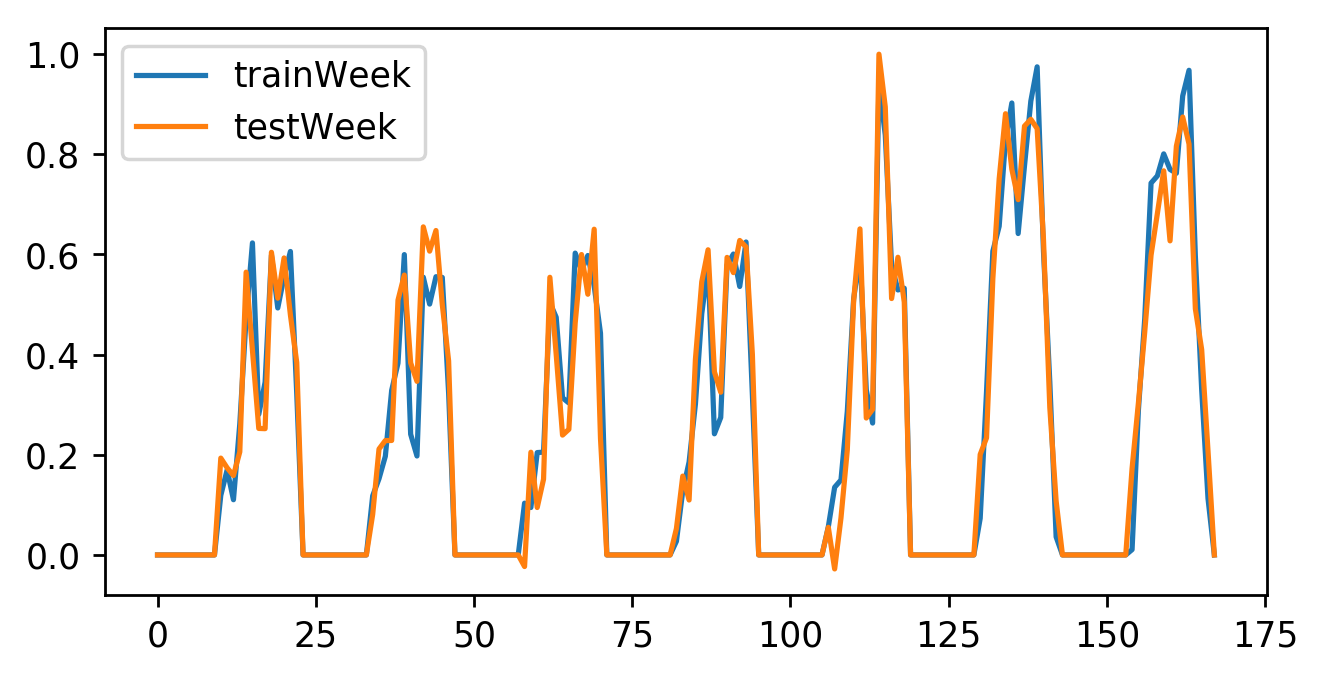

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import dataGenerator as gen

data_set, weekTest = gen.generate()

plt.figure(figsize = (6,3), dpi = 250)
plt.plot([d[0] for d in data_set[:24*7]], label = 'trainWeek')
plt.plot([d[0] for d in weekTest], label = 'testWeek')
plt.legend()
plt.yticks()
plt.show()


In [8]:
X, Y = models.pad_sequences(data_set)

Y = [d[0] for d in Y]

#history = models.fitModel(IRAM, X , Y, 'data/model_weights/RNN_Analys1', 
#                          val_rate = 0.1, epochs = 1000, batch_size = 128)

IRAM = models._load_model('data/model_weights/RNN_Analys')

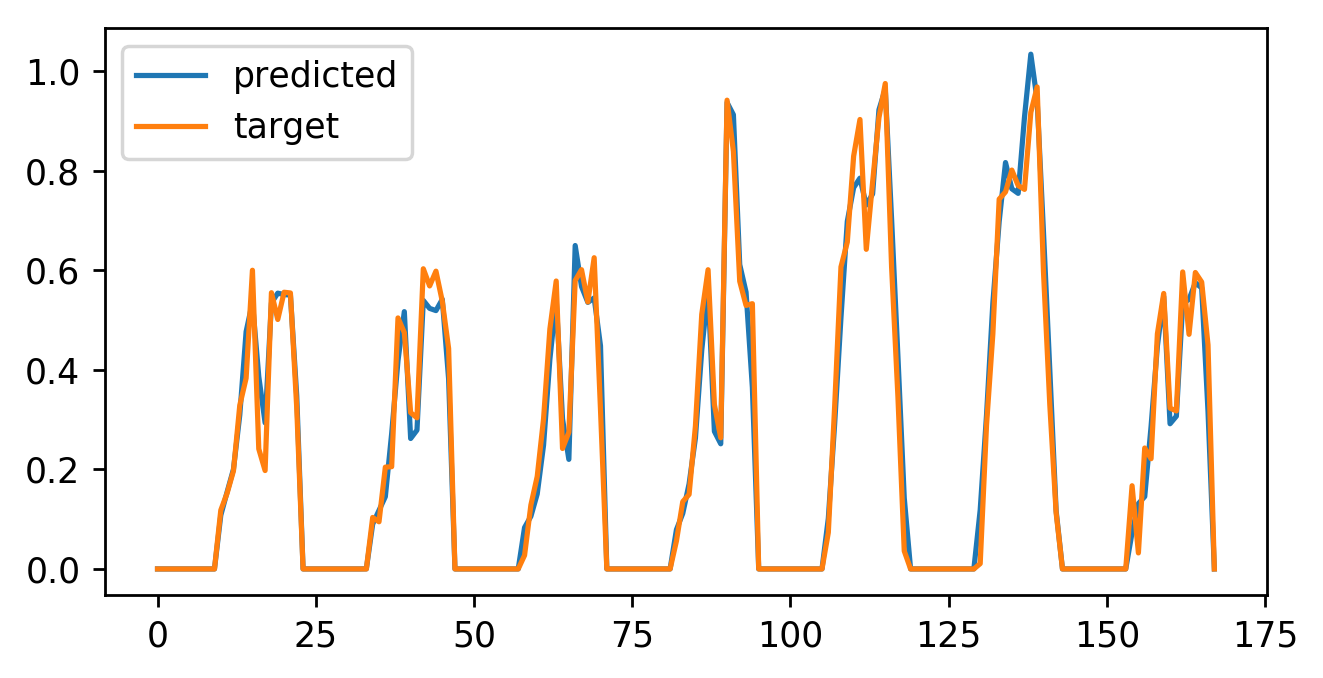

In [9]:
YP = IRAM.predict(X)

plt.figure(figsize = (6,3), dpi = 250)

plt.plot(YP[:24*7], label = "predicted")
plt.plot(Y[:24*7], label = "target")
plt.legend()
plt.show()

In [10]:
X, Y = models.pad_sequences(weekTest)

Y = [d[0] for d in Y]

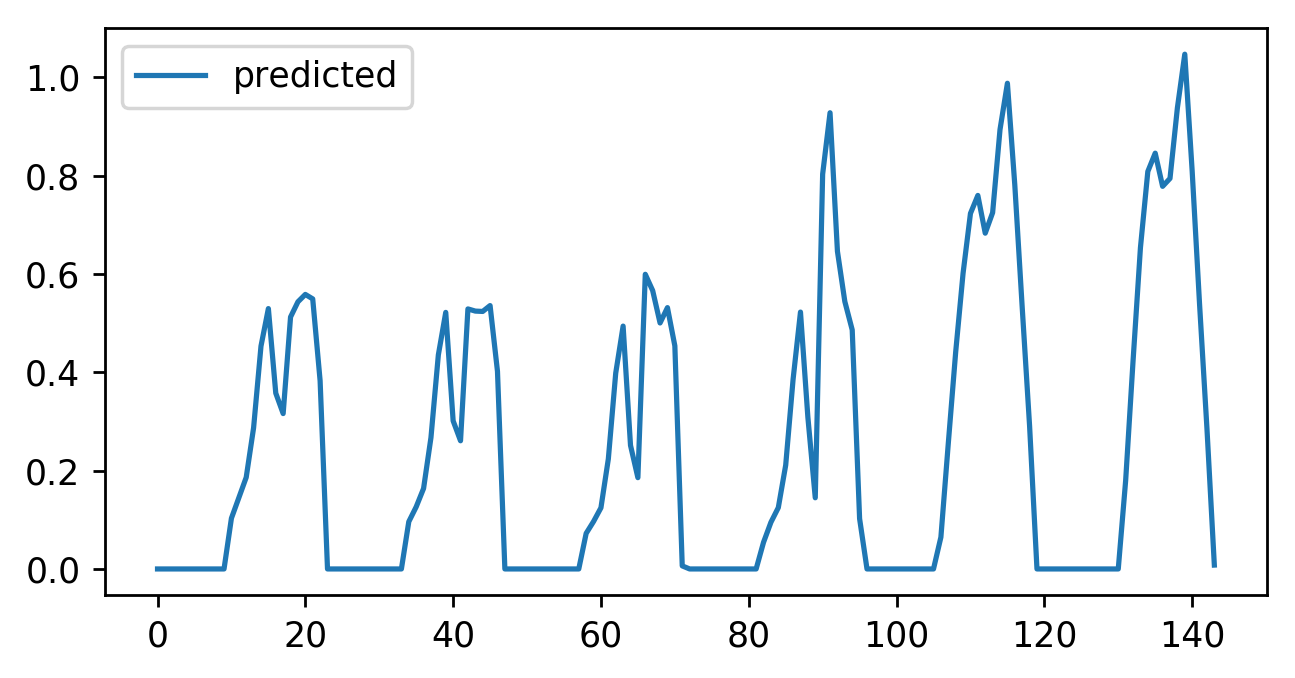

In [11]:
import numpy as np

_x = weekTest[:24]
YP = []
for i in range(len(weekTest) - 24):
    p = IRAM.predict(np.array([_x]))
    _x = _x[1:]
    _x.append([float(p),weekTest[24 + i][1]])
    YP.append(float(p))

plt.figure(figsize = (6,3), dpi = 250)

plt.plot(YP, label = "predicted")
#plt.plot(Y, label = "target")
plt.legend()
plt.show()

In [12]:
print(sum((np.array(YP) - np.array(Y))**2) / len(Y))

0.00656031258763336


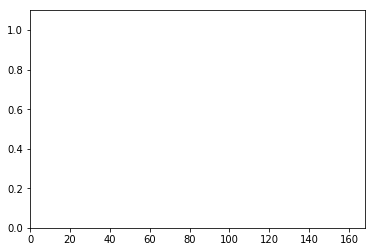

In [13]:
from matplotlib import animation


data_set, weekTest = gen.generate()

ANIMMODEL = models.IntensRecModelCreater(input_dim = 2, power = 128)()

batch_size = 128
frames = 100
Epoch = 0

X, Y = models.pad_sequences(data_set)

_, YT = models.pad_sequences(weekTest)

Y = [d[0] for d in Y]
YT = [d[0] for d in YT]

plotcols = ["g","b"]
labels = ["Target", "Predicted"]

fig = plt.figure()
ax1 = plt.axes(xlim=(0, 24*7), ylim=(0,1.1))
line, = ax1.plot([], [], lw=2)

lines = []
for index in range(2):
    lobj = ax1.plot([],[],lw=2,color=plotcols[index], label = labels[index])[0]
    lines.append(lobj)

    
def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    
    global ANIMMODEL
    global X
    global Y
    global YT
    global weekTest
    global Epoch
    global batch_size

    Epoch += 1
    
    X,Y = models._shuffle(X,Y)
    
    print(str(i) + ' Epoch')
    _ = models.fitModel(ANIMMODEL, X , Y, 'data/model_weights/RNN_Analys1', 
                          val_rate = 0.1, epochs = 1, batch_size = 128)
    
    _x = weekTest[:24]
    YP = []
    for i in range(len(weekTest) - 24):
        p = ANIMMODEL.predict(np.array([_x]))
        _x = _x[1:]
        _x.append([float(p),weekTest[24 + i][1]])
        YP.append(float(p))

    ylist = [YT,YP]
    xlist = [[j for j in range(len(YT))],[j for j in range(len(YT))]]

    for lnum,line in enumerate(lines):
        line.set_data(xlist[lnum],ylist[lnum])

        
    plt.title("Epoch: " + str(Epoch))
    plt.legend()
    plt.tight_layout()


    return lines

#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=frames, blit=True)

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

#anim.save('learn.mp4', writer=writer)

#anim.save('learn.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
